In [1]:
### BOE Data API
import requests
import io
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#### Downloading Mortgage Rate Data from the Bank of England

boe_mortgage_rates = {
    'IUMZO29': (2, 60, 'buy to let fixed'),
    'IUMZID4': (2, 75, 'buy to let fixed'),
    'IUMZO2A': (5, 60, 'buy to let fixed'),
    'IUMZO2B': (5, 75, 'buy to let fixed'),
    'IUMZICQ': (2, 60, 'fixed'),
    'IUMBV34': (2, 75, 'fixed'),
    'IUMZICR': (2, 85, 'fixed'),
    'IUMB482': (2, 90, 'fixed'),
    'IUM2WTL': (2, 95, 'fixed'),
    'IUMBV37': (3, 75, 'fixed'),
    'IUMZO27': (5, 60, 'fixed'),
    'IUMBV42': (5, 75, 'fixed'),
    'IUMZO28': (5, 90, 'fixed'),
    'IUM5WTL': (5, 95, 'fixed'),
    'IUMBV45': (10, 75, 'fixed'),
    'IUMBV48': (2, 75, 'variable'),
    'IUMB479': (2, 90, 'variable'),
    'IUM2WDT': (2, 95, 'variable'),
    'IUMTLMV': (0, 0, 'revert_rate'),
}

boe_govt_rataes = {
    'IUMASOIA':'SONIA Overnight Average Over Month',
    'IUMSOIA':'SONIA Overnight Month End'
}

def get_boe_data(codes, datefrom='01/Jan/2005', dateto='now'):

    url_endpoint = 'http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes'
    url_params = {
        'Datefrom': datefrom,
        'Dateto': dateto,
        'SeriesCodes': ','.join(codes),
        'CSVF': 'CN',
        'UsingCodes': 'Y',
        'VPD': 'Y',
        'VFD': 'N'
    }
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) '
                      'AppleWebKit/537.36 (KHTML, like Gecko) '
                      'Chrome/54.0.2840.90 '
                      'Safari/537.36'
    }
    
    response = requests.get(url_endpoint, params=url_params, headers=headers)

    if response.status_code == 200:
        mtg_data_raw = pd.read_csv(io.BytesIO(response.content), parse_dates=True)
        mtg_data_raw.DATE = pd.to_datetime(mtg_data_raw.DATE, format='%d %b %Y')
        return mtg_data_raw
        
    else:
        return response
    
mortgage_data_raw = get_boe_data(boe_mortgage_rates.keys())

<Axes: xlabel='months:'>

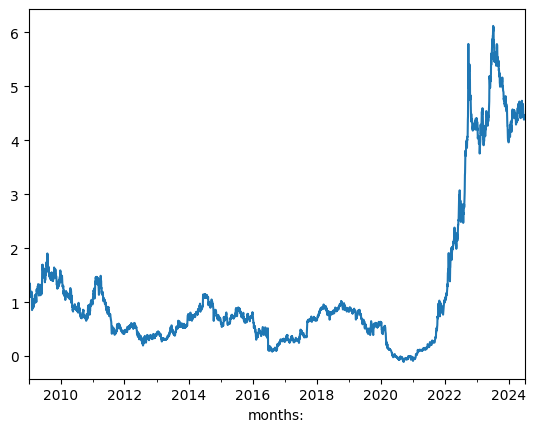

In [3]:
#### Downloading OIS Swap Data from the Bank of England

def get_swap_data():
    
    # Using saved OIS swap data as API is useless
    # Source: 'https://www.bankofengland.co.uk/-/media/boe/files/statistics/yield-curves/oisddata.zip'
    # The web address provided by the BoE yields javascript rather than directly yielding the zip file
    
    swap_data = pd.read_csv('./data/gbp_ois_spot_by_month_daily.csv', parse_dates=True, index_col=0)
    
    swap_data.ffill(inplace=True)
    
    return swap_data

temp = get_swap_data()

The Bank of England provides a weighted average of mortgage yields quoted by covered entities. This is provided for a number of LTV levels for 2Y fixed mortgages, as well as providing 3Y, 5Y and 10Y tenors for 75% mortgages

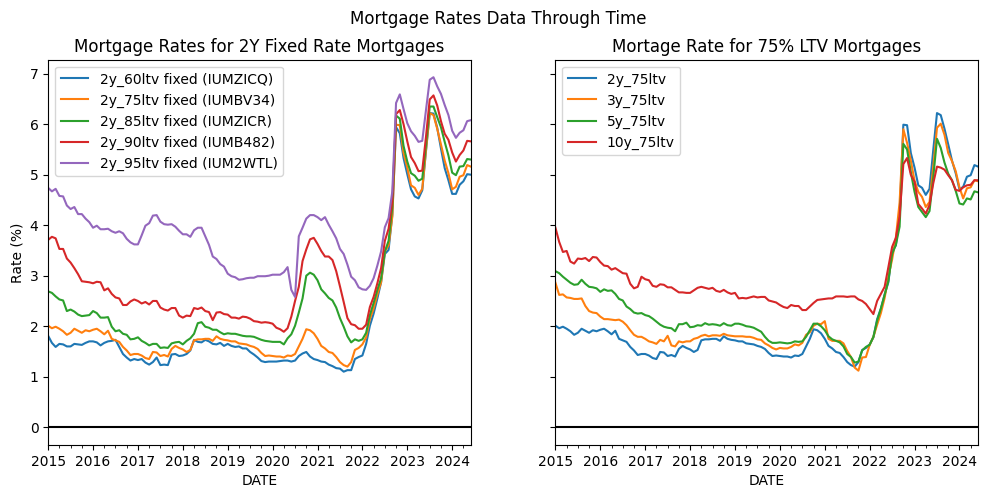

In [13]:
#### Mortgage Rate data

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5), sharex=True, sharey=True)
fig.suptitle('Mortgage Rates Data Through Time')

mortgage_data_ltv = pd.DataFrame(index=mortgage_data_raw.DATE.drop_duplicates().sort_values())
for mtg_code, mtg_char in boe_mortgage_rates.items():
    mtg_term, mtg_ltv, mtg_type = mtg_char
    if mtg_type in ['fixed'] and mtg_term == 2:# and mtg_ltv <= 85:
        col_name = f'{mtg_term}y_{mtg_ltv}ltv {mtg_type} ({mtg_code})'
        mortgage_data_ltv[col_name] = pd.to_numeric(mortgage_data_raw[mortgage_data_raw.SERIES == mtg_code].set_index('DATE').VALUE, errors='coerce')
mortgage_data_ltv.loc['2015-01-01':].plot(title='Mortgage Rates for 2Y Fixed Rate Mortgages', ax=ax1)
        
mortgage_data_term = pd.DataFrame(index=mortgage_data_raw.DATE.drop_duplicates().sort_values())
for mtg_code, mtg_char in boe_mortgage_rates.items():
    mtg_term, mtg_ltv, mtg_type = mtg_char
    if mtg_type in ['fixed'] and mtg_ltv == 75:
        col_name = f'{mtg_term}y_{mtg_ltv}ltv'
        mortgage_data_term[col_name] = pd.to_numeric(mortgage_data_raw[mortgage_data_raw.SERIES == mtg_code].set_index('DATE').VALUE, errors='coerce')
mortgage_data_term.loc['2015-01-01':].plot(title='Mortage Rate for 75% LTV Mortgages', ax=ax2)

ax1.set_ylabel('Rate (%)')
ax1.axhline(0, color='k')
ax2.axhline(0, color='k')

plt.savefig('raw_mortgage_yields.png')

In [5]:
mortgage_data = mortgage_data_ltv.copy()
mortgage_data.columns = [x for x in mortgage_data.columns.str.split(' ').str[0].str.split('_').str[1]]
mortgage_data.dropna(inplace=True)

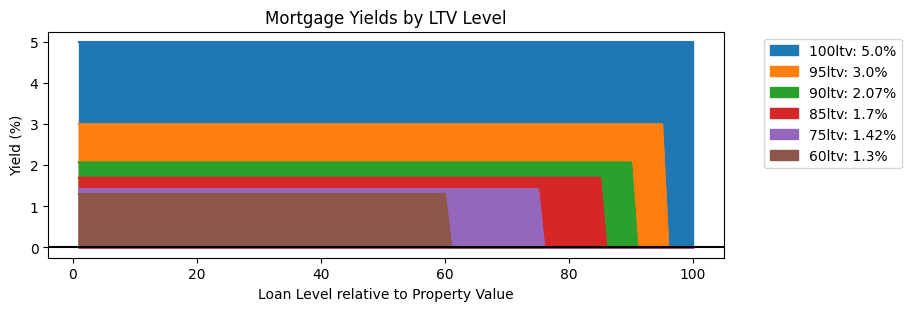

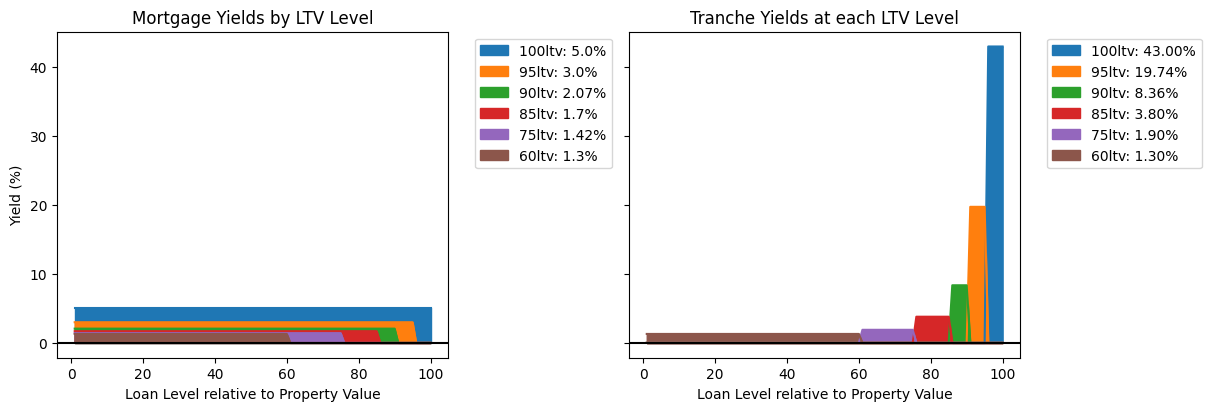

In [27]:
reference_date = '2019-12-31'

# Generate yields for reference date
ref_yield_table = mortgage_data.loc[[reference_date]].transpose().copy()
ref_yield_table.columns = ['raw_yields']
ref_yield_table.loc['100ltv', 'raw_yields'] = 5.

# Calculate tranche yields for each LTV level
ref_yield_table['ltv_level'] = ref_yield_table.index
ref_yield_table['ltv_level'] = ref_yield_table['ltv_level'].apply(lambda x: int(x[:-3]))
ref_yield_table['tranche_size'] = ref_yield_table['ltv_level'].diff().fillna(ref_yield_table.ltv_level)
ref_yield_table['tranche_yield'] =  (
        (ref_yield_table.raw_yields - ref_yield_table.raw_yields.shift(1)) * ref_yield_table.ltv_level.shift(1) / ref_yield_table.tranche_size
        + ref_yield_table.raw_yields
).fillna(ref_yield_table.raw_yields)

# Create yield table graph
yield_cols = {level: f'{level}: {yld}%' for level, yld in reversed(list(ref_yield_table['raw_yields'].items()))}
yield_by_level = pd.DataFrame(0., index=range(1,101), columns=list(yield_cols.values()))

# Plot yield levels
for ltv_level in ref_yield_table.index:
    for i in yield_by_level.index:
        if i<= int(ltv_level[:-3]):
            yield_by_level.loc[i, yield_cols[ltv_level]] = float(ref_yield_table.loc[ltv_level, 'raw_yields'])
  
fig, ax = plt.subplots(figsize=(9,3), constrained_layout=True)
yield_by_level.plot.area(stacked=False, ax=ax, title='Mortgage Yields by LTV Level', alpha=1)
ax.set_ylabel('Yield (%)')
ax.set_xlabel('Loan Level relative to Property Value')
ax.axhline(0, color='k')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('mortgage_yields_area_chart_2020.png')

# Create yield table graph
yield_cols = {level: f'{level}: {yld:0.2f}%' for level, yld in reversed(list(ref_yield_table['tranche_yield'].items()))}
tranche_by_ltv = pd.DataFrame(0., index=range(1,101), columns=list(yield_cols.values()))

# Plot tranche yields
ltv_level_index = 0
ltv_level  = ref_yield_table.index[ltv_level_index]
for i in tranche_by_ltv.index:
    if i > int(ltv_level[:-3]):
        ltv_level_index += 1
        ltv_level = ref_yield_table.index[ltv_level_index]
    tranche_by_ltv.loc[i, yield_cols[ltv_level]] = float(ref_yield_table.loc[ltv_level, 'tranche_yield'])
    
  
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharey=True, constrained_layout=True)
yield_by_level.plot.area(stacked=False, ax=ax1, title='Mortgage Yields by LTV Level', alpha=1)
ax1.set_ylabel('Yield (%)')
ax1.set_xlabel('Loan Level relative to Property Value')
ax1.axhline(0, color='k')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

tranche_by_ltv.plot.area(stacked=False, ax=ax2, title='Tranche Yields at each LTV Level', alpha=1)
ax2.set_ylabel('Yield (%)')
ax2.set_xlabel('Loan Level relative to Property Value')
ax2.axhline(0, color='k')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('mortgage_tranche_yields_area_chart_2020.png')

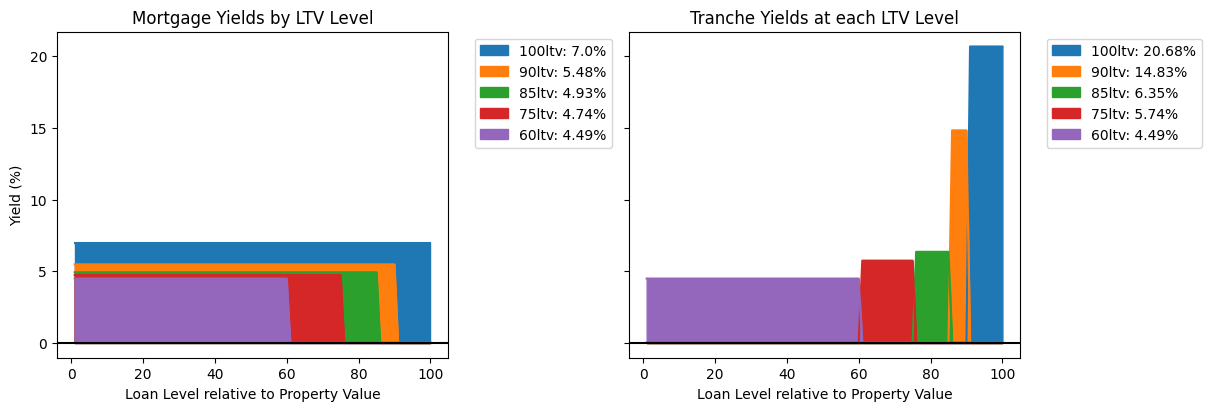

In [35]:
### Current mortgage yields from Barclays
# https://intermediaries.uk.barclays/content/dam/intermediaries-uk-barclays/pdf/buy-to-let/residential-and-buy-to-let-rates.pdf

# Generate yields for reference date
ref_yield_table = pd.DataFrame({'raw_yields': {'60ltv': 4.49, '75ltv': 4.74, '85ltv':4.93, '90ltv': 5.48}})
ref_yield_table.columns = ['raw_yields']
ref_yield_table.loc['100ltv', 'raw_yields'] = 7

# Create yield table graph
yield_cols = {level: f'{level}: {yld}%' for level, yld in reversed(list(ref_yield_table['raw_yields'].items()))}
yield_by_level = pd.DataFrame(0., index=range(1,101), columns=list(yield_cols.values()))

# Plot yield levels
for ltv_level in ref_yield_table.index:
    for i in yield_by_level.index:
       if i<= int(ltv_level[:-3]):
            yield_by_level.loc[i, yield_cols[ltv_level]] = float(ref_yield_table.loc[ltv_level, 'raw_yields'])

# Calculate tranche yields for each LTV level
ref_yield_table['ltv_level'] = ref_yield_table.index
ref_yield_table['ltv_level'] = ref_yield_table['ltv_level'].apply(lambda x: int(x[:-3]))
ref_yield_table['tranche_size'] = ref_yield_table['ltv_level'].diff().fillna(ref_yield_table.ltv_level)
ref_yield_table['tranche_yield'] =  (
        (ref_yield_table.raw_yields - ref_yield_table.raw_yields.shift(1)) * ref_yield_table.ltv_level.shift(1) / ref_yield_table.tranche_size
        + ref_yield_table.raw_yields
).fillna(ref_yield_table.raw_yields)

# Create yield table graph
yield_cols = {level: f'{level}: {yld:0.2f}%' for level, yld in reversed(list(ref_yield_table['tranche_yield'].items()))}
tranche_by_ltv = pd.DataFrame(0., index=range(1,101), columns=list(yield_cols.values()))

# Plot tranche yields
ltv_level_index = 0
ltv_level  = ref_yield_table.index[ltv_level_index]
for i in tranche_by_ltv.index:
    if i > int(ltv_level[:-3]):
        ltv_level_index += 1
        ltv_level = ref_yield_table.index[ltv_level_index]
    tranche_by_ltv.loc[i, yield_cols[ltv_level]] = float(ref_yield_table.loc[ltv_level, 'tranche_yield'])
    
  
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharey=True, constrained_layout=True)
yield_by_level.plot.area(stacked=False, ax=ax1, title='Mortgage Yields by LTV Level', alpha=1)
ax1.set_ylabel('Yield (%)')
ax1.set_xlabel('Loan Level relative to Property Value')
ax1.axhline(0, color='k')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

tranche_by_ltv.plot.area(stacked=False, ax=ax2, title='Tranche Yields at each LTV Level', alpha=1)
ax2.set_ylabel('Yield (%)')
ax2.set_xlabel('Loan Level relative to Property Value')
ax2.axhline(0, color='k')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('mortgage_tranche_yields_area_chart_current.png')

In [21]:
#### Tranching the Mortgage LTV Curve

mortgage_data = pd.DataFrame(index=mortgage_data_raw.DATE.drop_duplicates().sort_values())
for mtg_code, mtg_char in boe_mortgage_rates.items():
    mtg_term, mtg_ltv, mtg_type = mtg_char
    if mtg_type in ['fixed'] and mtg_term == 2:# and mtg_ltv <= 85:
        col_name = f'{mtg_ltv}ltv'
        mortgage_data[col_name] = pd.to_numeric(mortgage_data_raw[mortgage_data_raw.SERIES == mtg_code].set_index('DATE').VALUE, errors='coerce')

mortgage_data.dropna(subset=['60ltv', '75ltv'], inplace=True)

In [31]:
mortgage_tranches = pd.DataFrame(index=mortgage_data.index)
ltv_cutoffs = [60,75,85,90,95]

# Calculate mortgage tranche yields
mortgage_tranches[f'0_{ltv_cutoffs[0]}ltv'] = mortgage_data[f'{ltv_cutoffs[0]}ltv']
for i in range(len(ltv_cutoffs)-1):
    ltv_low, ltv_high = ltv_cutoffs[i], ltv_cutoffs[i+1]
    mortgage_tranches[f'{ltv_low}_{ltv_high}ltv'] = (mortgage_data[f'{ltv_high}ltv']*ltv_high - mortgage_data[f'{ltv_low}ltv']*ltv_low) / (ltv_high-ltv_low) 

# Calculate tranche spreads
mortgage_tranche_spreads = mortgage_tranches.copy()
for col in mortgage_tranche_spreads.columns:
    if col == [f'0_{ltv_cutoffs[0]}ltv']:
        mortgage_tranche_spreads[col] = 0.
    else:
        mortgage_tranche_spreads[col] = mortgage_tranche_spreads[col] - mortgage_tranches[f'0_{ltv_cutoffs[0]}ltv']

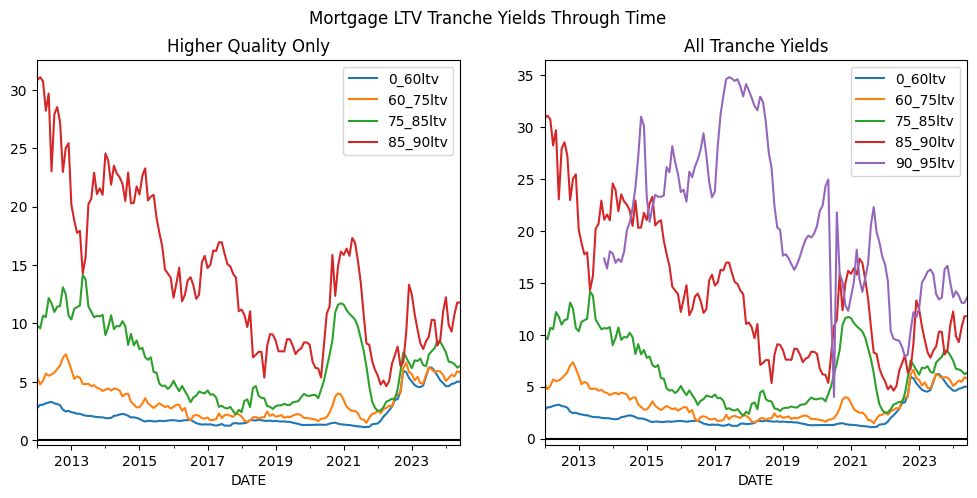

In [32]:
# Plot mortgage tranche yields 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5), sharex=True, sharey=False)
fig.suptitle('Mortgage LTV Tranche Yields Through Time')
mortgage_tranches[[x for x in mortgage_tranches.columns if '95' not in x]].plot(ax=ax1, title='Higher Quality Only')
mortgage_tranches.plot(ax=ax2, title='All Tranche Yields')
ax1.axhline(0, color='k')
ax2.axhline(0, color='k')

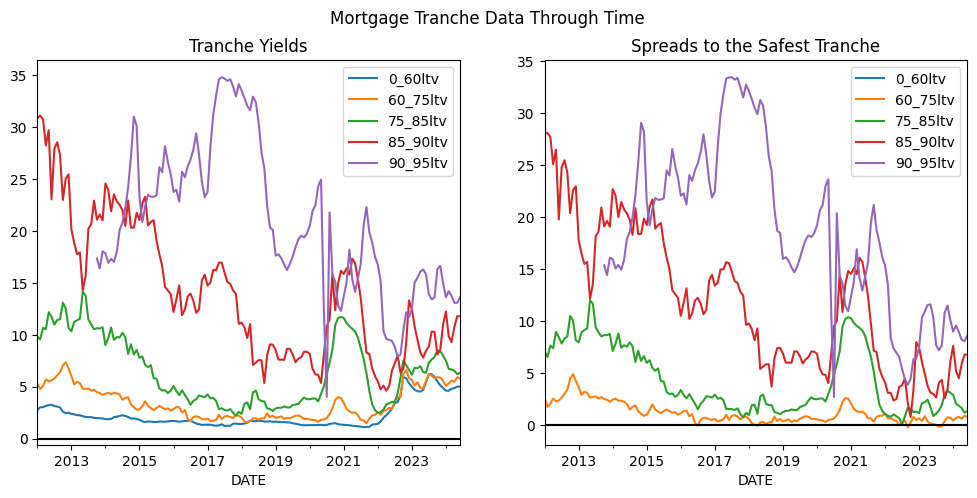

In [33]:
# Plot mortgage tranche yields 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5), sharex=True, sharey=False)
fig.suptitle('Mortgage Tranche Data Through Time')
mortgage_tranches#[[x for x in mortgage_tranches.columns if '95' not in x]].plot(ax=ax1, title='Higher Quality Only')
mortgage_tranches.plot(ax=ax1, title='Tranche Yields')
#mortgage_tranche_spreads[[x for x in mortgage_tranche_spreads.columns if '95' not in x]].plot(ax=ax1, title='Higher Quality Spreads Only')
mortgage_tranche_spreads.plot(ax=ax2, title='Spreads to the Safest Tranche')
ax1.axhline(0, color='k')
ax2.axhline(0, color='k')

plt.savefig('mortgage_tranche_yields_timeseries.png')